### MNIST: the "Hello World" of Machine Learning

In [1]:
# Alternative local file loader (due to mldata.org being down)

from scipy.io import loadmat
mnist_raw = loadmat("mnist-original.mat")
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
    }

In [2]:
# 70K images, 28x28 pixels/image, each pixel = 0 (white) to 255 (black)
mnist # a dict object

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
# take a peek
X,y = mnist['data'], mnist['target']

X.shape, y.shape

((70000, 784), (70000,))

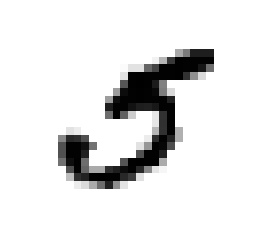

In [4]:
# display example image

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(
    some_digit_image, 
    cmap = matplotlib.cm.binary,
    interpolation="nearest")

plt.axis("off")
plt.show()

In [5]:
# looks like a "five". What's the corresponding label?
y[36000]

5.0

In [6]:
# dataset already split into training (1st 60K) & test (last 10K) images.
# shuffle training set for cross-validation quality

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


### Binary classifier training - distinguish between 2 classes
* Using Stochastic Descent

In [7]:
# Start by only trying to ID "five" digits.

y_train_5 = (y_train == 5) # create target vectors
y_test_5  = (y_test == 5)

print(y_train_5.shape, y_train_5)
print(y_test_5.shape, y_test_5)

# SGD classifier: good at handling large DBs
#                 also good at handling one-at-a-time learning

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# did it correctly predict the "five" found above?
print(sgd_clf.predict([some_digit]))

(60000,) [False False False ..., False False False]
(10000,) [False False False ..., False False False]
[ True]


### Performance Measures

In [8]:
# measure accuracy using K-fold (n=3) cross-validation scores

from sklearn.model_selection import cross_val_score

print(cross_val_score(
        sgd_clf, 
        X_train, 
        y_train_5, 
        cv=3, 
        scoring="accuracy"))

# 90% accuracy = pretty easy when 90% of digits aren't fives to begin with ... :-|

[ 0.96795  0.96975  0.96855]


In [9]:
# rolling your own cross-validation. Results should be similar-ish to above.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    clone_clf = clone(sgd_clf)
    
    X_train_folds =  X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold =    X_train[test_index]
    y_test_fold =   (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.96795
0.96975
0.96855


In [10]:
# 95% accuracy sounds too good to be true. How about not-fives?

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()

print(cross_val_score(
    never_5_clf,
    X_train,
    y_train_5,
    cv=3,
    scoring="accuracy"))

[ 0.9096   0.9124   0.90695]


In [11]:
# only ~10% of images are "five", so ~90% of images are "not five". 
# You SHOULD be right about 90% of the time. :-)

# Lesson Learned:
# Accuracy not a good metric for classifiers - esp those with skewed datasets.

### Confusion Matrix - a better way of evaluating a classifier

In [12]:
# general idea: count #times instances of A are classified as B.
# first, need a set of predictions.

from sklearn.model_selection import cross_val_predict

# Generate cross-val'd predictions for each datapoint
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# ROWS = actual classes
# COLS = predicted classes

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train_5, y_train_pred))

[[54044   535]
 [ 1340  4081]]


### Classifier metrics: precision = TP/(TP+FP); recall (sensitivity) = TP/(TP+FN)
![alt text](pics/precision-recall-50pct.png "Logo Title Text 1")

In [13]:
print(3841 / (3841+1515), 3841/(3841+1580))

0.7171396564600448 0.7085408596199964


In [14]:
# precision, recall, f1 metrics
# precision/recall tradeoff: increasing one reduces the other.

from sklearn.metrics import precision_score, recall_score, f1_score
print("precision:\n",precision_score(y_train_5, y_train_pred))
print("recall:\n",recall_score(y_train_5, y_train_pred))

# F1 score favors classifiers with similar precision & recall.
print("f1:\n",f1_score(y_train_5, y_train_pred))

precision:
 0.884098786828
recall:
 0.752813134108
f1:
 0.813191192587


### Precision/Recall Tradeoffs

In [15]:
# Scikit doesn't let you directly set threshold values (which drive the decision
# function for precision/recall.) But you can use the decision function itself.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold) 
print(y_some_digit_pred)

[ 57844.42736708]
[ True]


In [16]:
# raising the threshold reduces recall...

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


![tradeoff](pics/decision-threshold-and-precision-vs-recall.png)

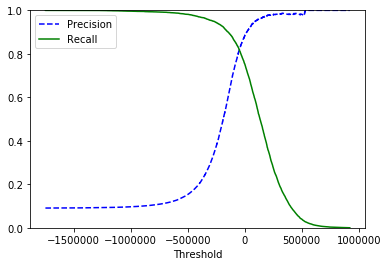

In [17]:
# how to find the right threshold?
# start with getting decision scores instead of predictions.

y_scores = cross_val_predict(
    sgd_clf, 
    X_train, 
    y_train_5, 
    cv=3,
    method="decision_function")

# use results to build a precision/recall curve

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# plot the result

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, 
             precisions[:-1], 
             "b--", 
             label="Precision")
    plt.plot(thresholds, 
             recalls[:-1], 
             "g-", 
             label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

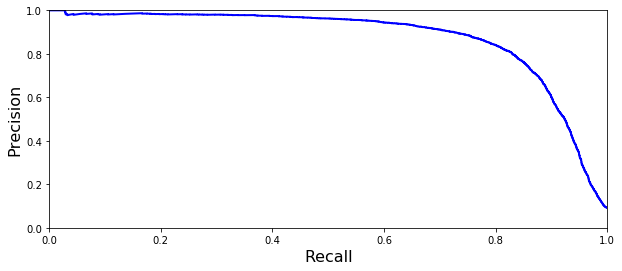

In [18]:
# plot precision vs recall to look for knee of the curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(10, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [19]:
# assume you're targeting 90% precision:
# guesswork from precision-recall curve suggests setting threshold ~50000

y_train_pred_90 = (y_scores > 50000)
print(y_train_pred_90.shape, y_train_pred_90)

print("precision:\n",precision_score(y_train_5, y_train_pred_90))
print("recall:\n",recall_score(y_train_5, y_train_pred_90))

(60000,) [False False False ..., False False False]
precision:
 0.924948770492
recall:
 0.666113263236


### ROC (Receiver Operating Characteristic) curve

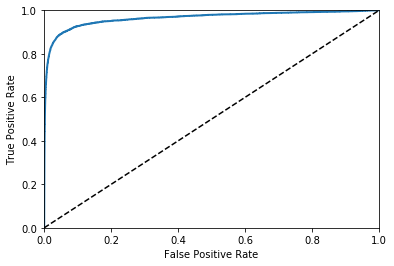

In [20]:
# ROC plots TRUE POSITIVE rate (TP = recall) vs FALSE POSITIVE rate. (FP = 1-specificity)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

# tradeoff: higher recall (TP) => more false positives produced.
# dotted line = purely random classifier results.

In [21]:
# area under curve (AUC) metric:
# perfect score = ROC AUC = 1.0
# random score = ROC AUC = 0.5

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.964880839199


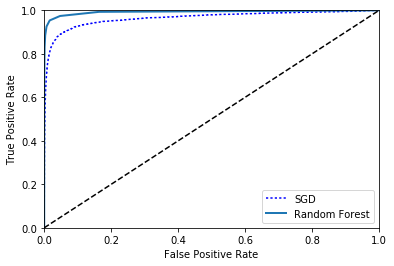

In [22]:
# train Random Forest classifier
# compare its ROC curve & AUC to SGD classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# Random Forest doesn't have decision_function(); use predict_proba() instead.
# returns array (row per instance, column per class)

y_probas_forest = cross_val_predict(
    forest_clf, 
    X_train, 
    y_train_5, 
    cv=3,
    method="predict_proba")

# To plot ROC curve, you need scores - not probabilities.
# use positive class probability as the score.

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# plot ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [23]:
# Random Forest curve looks much steeper (better). How's the ROC AUC score?
print(roc_auc_score(y_train_5, y_scores_forest))

# How's the precision & recall?
y_train_pred_forest = cross_val_predict(
    forest_clf, 
    X_train, 
    y_train_5, 
    cv=3)

print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))


0.992589481683
0.985567461185
0.831396421324


### Multiclass Classification

In [24]:
# some algorithms (RF, Bayes, ..) can handle multiple classes
# others (SVMs, linear, ...) cannot

# one-vs-all (OVA) strategy for 0-9 digit classication:
# 10 binary classifiers, one for each digit -- select class with highest score

# one-vs-one (OVO) strategy:
# train classifiers for every PAIR of digits -- N*(N-1)/2 classifiers needed!

# Scikit detects using binary classifier when multi-class problem is present,
# auto-selects OVA.

sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit])) # can SGD correctly predict the "five"?

[ 5.]


In [25]:
# let's see 10 scores, one per class. 
# highest score corresponds to "five".

some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(sgd_clf.classes_)

[[-177277.32782496 -561668.18573184 -385895.43788059 -114677.95360751
  -410210.58824666   57844.42736708 -654717.63929413 -200777.6510135
  -772154.70175904 -614737.18986655]]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


In [26]:
# to force Scikit to use OVO (in this case) or OVA: use corresponding classifier.

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print("prediction:\n",ovo_clf.predict([some_digit]))

# same thing for Random Forest (RF can directly handle multiple classifications)
forest_clf.fit(X_train, y_train)
print("prediction via Random Forest:\n",forest_clf.predict([some_digit]))
print("probability via Random Forest:\n",forest_clf.predict_proba([some_digit]))

prediction:
 [ 5.]
prediction via Random Forest:
 [ 5.]
probability via Random Forest:
 [[ 0.1  0.   0.   0.1  0.   0.8  0.   0.   0.   0. ]]


In [27]:
# let's check these classifiers via CV. SGD first.

print("CV score:\n",cross_val_score(
    sgd_clf, 
    X_train, 
    y_train, 
    cv=3, 
    scoring="accuracy"))

CV score:
 [ 0.84843031  0.85419271  0.81062159]


In [28]:
# scaling the inputs should help improve the scores.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print("CV score, scaled inputs:\n",cross_val_score(
    sgd_clf, 
    X_train_scaled, 
    y_train, 
    cv=3, 
    scoring="accuracy"))

CV score, scaled inputs:
 [ 0.91011798  0.91089554  0.90908636]


### Error Analysis

confusion matrix:
 [[5735    4   24   11   13   45   43    8   37    3]
 [   1 6489   43   24    6   35    8    8  116   12]
 [  57   38 5329   88   79   27   92   60  174   14]
 [  53   41  140 5333    2  234   35   60  142   91]
 [  17   26   36   10 5371    8   48   30   77  219]
 [  69   38   39  185   76 4600  114   28  175   97]
 [  34   24   42    2   41   95 5625    7   48    0]
 [  22   21   64   31   49    9    8 5792   14  255]
 [  54  157   70  148   14  158   58   28 5029  135]
 [  42   37   25   85  155   36    2  193   75 5299]]


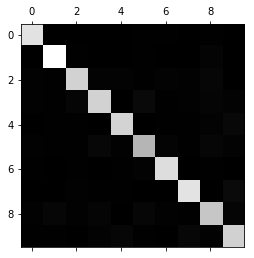

In [29]:
# as earlier: a confusion matrix from the SGD classificer

y_train_pred = cross_val_predict(
    sgd_clf, 
    X_train_scaled, 
    y_train, 
    cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
print("confusion matrix:\n",conf_mx)

# image equivalent
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

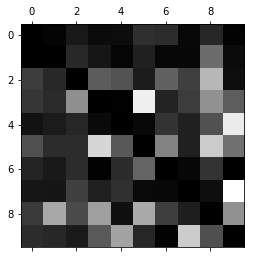

In [30]:
# focus on errors.
# 1st: divide each value in confusion matrix by #images in corresponding class
# (compares error rates instead of #errors)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill diagonals with zeroes to keep only the errors, and plot.
# brighter colors = more misclassifications

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# rows = actual classes
# cols = predicted classes
# 8s & 9s are a problem.

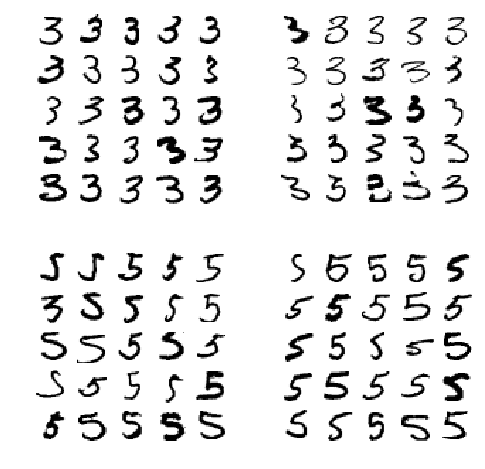

In [31]:
# more on analyzing individual errors

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# shows difficulty in seeing difference between threes and fives.
# We used SGDclassifier, which is sensitive to image shifts/rotates.

### MultiLabel Classification

In [32]:
# use case: returning multiple classes for each instance
# (example: multiple people's faces in one picture.)

# create y_multilabel array with 2 target labels for each digit image:
# first = large digit (7,8,9)?; second = odd (1,3,5,7,9)?


from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

print("large nums?\n",y_train_large)
print("odd nums?\n",y_train_odd)

y_multilabel = np.c_[y_train_large, y_train_odd]

print("combined (multilabel)?\n",y_multilabel)

# KNeighbors classifier supports multilabeling

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# make example prediction using "some_digit" from above
# >= 7 = false (correct); odd digit = true (correct)

print("KNN prediction of some_digit: (>=7? odd?)\n",knn_clf.predict([some_digit]))


large nums?
 [False False  True ..., False False False]
odd nums?
 [False False  True ..., False False False]
combined (multilabel)?
 [[False False]
 [False False]
 [ True  True]
 ..., 
 [False False]
 [False False]
 [False False]]
KNN prediction of some_digit: (>=7? odd?)
 [[False  True]]


In [33]:
# another example: find avg F1 score across all labels

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

print(f1_score(
    y_train, 
    y_train_knn_pred, 
    average="macro")) # use "weighted" if more weight to be given to more common labels.

0.968186511757


### MultiOutput Classification

In [36]:
# generalization of multilabel, where each label can have multiple values.
# example: build image noise removal system

# start by adding noise to MNIST dataset

import numpy.random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

some_index = 5500

In [40]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

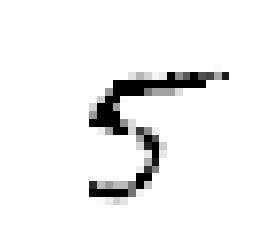

In [41]:
# train classifier, and clean up the image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)

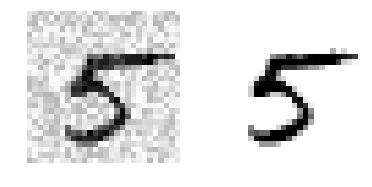

In [42]:
some_index = 5500

plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

# left: noisy image; right: cleaned up